In [1]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import shift, map_coordinates, gaussian_filter
from sklearn.model_selection import StratifiedKFold 
from sklearn.utils.class_weight import compute_class_weight

2025-01-11 19:28:01.929296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 19:28:01.947381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 19:28:01.965288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 19:28:01.970232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 19:28:01.984562: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def split_dataset(x_test, y_test_encoded, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

In [2]:
## for train and test with 90:10 ratio analysis load them ##
x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy')
y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy')
# x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_data.npy')
# y_train_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_label.npy')

In [4]:
# Split into 2 parts
splits = split_dataset(x_train, y_train_encoded, num_splits=2)
x1 = splits[0][0]
y1_encoded = to_categorical(splits[0][1])

x2 = splits[1][0]
y2_encoded = to_categorical(splits[1][1])

2it [00:12,  6.15s/it]


In [5]:
del x_train
del y_train_encoded

In [6]:
print(x1.shape)
print(y1_encoded.shape)
print(x2.shape)
print(y2_encoded.shape)

(114360, 128, 128, 3)
(114360, 16)
(114360, 128, 128, 3)
(114360, 16)


In [3]:
## for train and test analysis load them ##
x_test2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy')
y_test_encoded2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy')
# x_train2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_data.npy')
# y_train2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_label.npy')

In [4]:
## for train and test with 70:30 ratio analysis load them ##
x_test3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_data.npy')
y_test_encoded3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_label_enc.npy')
# x_train3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_data.npy')
# y_train3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_label.npy')

In [9]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

def scale_image(image, scale_factor):
    """
    Scale the image by a given scale factor.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    scaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Crop or pad the image back to the original size
    if scale_factor > 1:
        # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return scaled_image[start_h:start_h + h, start_w:start_w + w]
    else:
        # Pad with zeros
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        return np.pad(
            scaled_image,
            ((pad_h, h - new_h - pad_h), (pad_w, w - new_w - pad_w), (0, 0)),
            mode='constant',
            constant_values=0
        )
        
def elastic_transform_2d(image, alpha, sigma=8, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    #print(random_state)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')  #wrap,reflect, nearest
    return distored_image.reshape(image.shape)


## Perform horizontal and vertical flips
x_train_hflip = np.flip(x_train2[0:212], axis=2)  # Horizontal flip (flip along width)
y_train_hflip = y_train2[0:212]
x_train_vflip = np.flip(x_train2[0:212], axis=1)  # Vertical flip (flip along height)
y_train_vflip = y_train2[0:212]

## Combine original and augmented data
x_train_augmented = np.concatenate((x_train2, x_train_hflip, x_train_vflip), axis=0)
y_train_augmented = np.concatenate((y_train2, y_train_hflip, y_train_vflip), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train2.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)
del x_train_hflip
del x_train_vflip


# Create translated datasets
x_train_translated_pos = np.array([translate_image(img, 20, 20) for img in tqdm(x_train2[0:956])])  # +10 pixels in both directions
y_train_tpos = y_train2[0:956]
x_train_translated_neg = np.array([translate_image(img, -20, -20) for img in tqdm(x_train2[0:956])])  # -10 pixels in both directions
y_train_tneg = y_train2[0:956]

# Combine original and translated data
x_train_augmented = np.concatenate((x_train_augmented, x_train_translated_pos, x_train_translated_neg), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_tpos, y_train_tneg), axis=0)

# Check the shapes for confirmation
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)
del x_train_translated_pos
del x_train_translated_neg

# Apply scaling
x_train_scaled_up = np.array([scale_image(img, 1.10) for img in tqdm(x_train2[3383:3944])])  # +2% scaling
y_train_scaled_up = y_train2[3383:3944]
x_train_scaled_down = np.array([scale_image(img, 0.90) for img in tqdm(x_train2[3383:3944])])  # -2% scaling
y_train_scaled_down = y_train2[3383:3944]

# Combine original and scaled datasets
x_train_augmented = np.concatenate((x_train_augmented, x_train_scaled_up, x_train_scaled_down), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_scaled_up, y_train_scaled_down), axis=0)

# Check the shapes for confirmation
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)
del x_train_scaled_up
del x_train_scaled_down

img_aug_array=[]
label_array = []
alphas = [1000, 800]
for d in tqdm(range(3383, 3944)):
    for e in range (2):
            volume = elastic_transform_2d(x_train2[d], alpha=alphas[e])
            img_aug_array.append(volume)
            label = y_train2[d]
            label_array.append(label)

x_aug_et = np.array(img_aug_array, np.float32)
x_train_augmented2 = np.concatenate((x_train_augmented, x_aug_et), axis=0)
y_aug = np.array(label_array, np.float32)
y_train_augmented = np.concatenate((y_train_augmented, y_aug), axis=0)
print("Augmented dataset shape:", x_train_augmented2.shape)
print("Augmented labelshape:", y_train_augmented.shape)
del x_aug_et
y_train_encoded2 = to_categorical(y_train_augmented)

Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (10599, 128, 128, 3)
Augmented label shape: (10599,)


100%|█████████████████████████████████████████████████████████████████████████████████| 956/956 [00:14<00:00, 65.98it/s]


Augmented dataset shape: (12511, 128, 128, 3)
Augmented label shape: (12511,)


100%|███████████████████████████████████████████████████████████████████████████████| 561/561 [00:00<00:00, 7683.81it/s]


Augmented dataset shape: (13633, 128, 128, 3)
Augmented label shape: (13633,)


100%|█████████████████████████████████████████████████████████████████████████████████| 561/561 [00:14<00:00, 39.54it/s]


Augmented dataset shape: (14755, 128, 128, 3)
Augmented labelshape: (14755,)


In [10]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

def scale_image(image, scale_factor):
    """
    Scale the image by a given scale factor.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    scaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Crop or pad the image back to the original size
    if scale_factor > 1:
        # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return scaled_image[start_h:start_h + h, start_w:start_w + w]
    else:
        # Pad with zeros
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        return np.pad(
            scaled_image,
            ((pad_h, h - new_h - pad_h), (pad_w, w - new_w - pad_w), (0, 0)),
            mode='constant',
            constant_values=0
        )
        
def elastic_transform_2d(image, alpha, sigma=8, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    #print(random_state)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')  #wrap,reflect, nearest
    return distored_image.reshape(image.shape)


## Perform horizontal and vertical flips
x_train_hflip = np.flip(x_train3, axis=2)  # Horizontal flip (flip along width)
y_train_hflip = y_train3
x_train_vflip = np.flip(x_train3, axis=1)  # Vertical flip (flip along height)
y_train_vflip = y_train3

## Combine original and augmented data
x_train_augmented3 = np.concatenate((x_train3, x_train_hflip, x_train_vflip), axis=0)
y_train_augmented3 = np.concatenate((y_train3, y_train_hflip, y_train_vflip), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train3.shape)
print("Augmented dataset shape:", x_train_augmented3.shape)
print("Augmented label shape:", y_train_augmented3.shape)
del x_train_hflip
del x_train_vflip


## Create translated datasets
x_train_translated_pos = np.array([translate_image(img, 20, 20) for img in tqdm(x_train3)])  # +20 pixels in both directions
y_train_tpos = y_train3
x_train_translated_neg = np.array([translate_image(img, -20, -20) for img in tqdm(x_train3)])  # -20 pixels in both directions
y_train_tneg = y_train3

# Combine original and translated data
x_train_augmented3 = np.concatenate((x_train_augmented3, x_train_translated_pos, x_train_translated_neg), axis=0)
y_train_augmented3 = np.concatenate((y_train_augmented3, y_train_tpos, y_train_tneg), axis=0)

## Check the shapes for confirmation
print("Augmented dataset shape:", x_train_augmented3.shape)
print("Augmented label shape:", y_train_augmented3.shape)
del x_train_translated_pos
del x_train_translated_neg

## Apply scaling
x_train_scaled_up = np.array([scale_image(img, 1.10) for img in tqdm(x_train3)])  # +10% scaling
y_train_scaled_up = y_train3
x_train_scaled_down = np.array([scale_image(img, 0.90) for img in tqdm(x_train3)])  # -10% scaling
y_train_scaled_down = y_train3

## Combine original and scaled datasets
x_train_augmented3 = np.concatenate((x_train_augmented3, x_train_scaled_up, x_train_scaled_down), axis=0)
y_train_augmented3 = np.concatenate((y_train_augmented3, y_train_scaled_up, y_train_scaled_down), axis=0)

# Check the shapes for confirmation
print("Augmented dataset shape:", x_train_augmented3.shape)
print("Augmented label shape:", y_train_augmented3.shape)
del x_train_scaled_up
del x_train_scaled_down

img_aug_array=[]
label_array = []
alphas = [900, 600] #900, 600
for d in tqdm(range(len(x_train3))):
    for e in range (2): #2
            volume = elastic_transform_2d(x_train3[d], alpha=alphas[e])
            img_aug_array.append(volume)
            label = y_train3[d]
            label_array.append(label)

x_aug_et = np.array(img_aug_array, np.float32)
x_train_augmented3 = np.concatenate((x_train_augmented3, x_aug_et), axis=0)
y_aug = np.array(label_array, np.float32)
y_train_augmented3 = np.concatenate((y_train_augmented3, y_aug), axis=0)
print("Augmented dataset shape:", x_train_augmented3.shape)
print("Augmented labelshape:", y_train_augmented3.shape)
del x_aug_et
y_train_encoded3 = to_categorical(y_train_augmented3)

Original dataset shape: (11960, 128, 128, 3)
Augmented dataset shape: (35880, 128, 128, 3)
Augmented label shape: (35880,)


100%|█████████████████████████████████████████████████████████████████████████████| 11960/11960 [03:05<00:00, 64.42it/s]


Augmented dataset shape: (59800, 128, 128, 3)
Augmented label shape: (59800,)


100%|███████████████████████████████████████████████████████████████████████████| 11960/11960 [00:02<00:00, 5277.20it/s]


Augmented dataset shape: (83720, 128, 128, 3)
Augmented label shape: (83720,)


100%|█████████████████████████████████████████████████████████████████████████████| 11960/11960 [04:49<00:00, 41.30it/s]


Augmented dataset shape: (107640, 128, 128, 3)
Augmented labelshape: (107640,)


In [8]:
# x1 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client1_data.npy')
# x2 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client2_data.npy')
# x3 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client3_data.npy')
# x4 = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client4_data.npy')

# y1_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client1_label.npy')
# y2_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client2_label.npy')
# y3_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client3_label.npy')
# y4_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/federated/client4_label.npy')

In [11]:
# Split into 20 parts
splits1 = split_dataset(x_test, y_test_encoded, num_splits=20)
x_val = splits1[0][0]
y_val_encoded = to_categorical(splits1[0][1])

# # Split into 3 parts
# splits3 = split_dataset(x_test3, y_test_encoded3, num_splits=3)
# x_val3 = splits3[0][0]
# y_val_encoded3 = to_categorical(splits3[0][1])

20it [00:01, 17.00it/s]


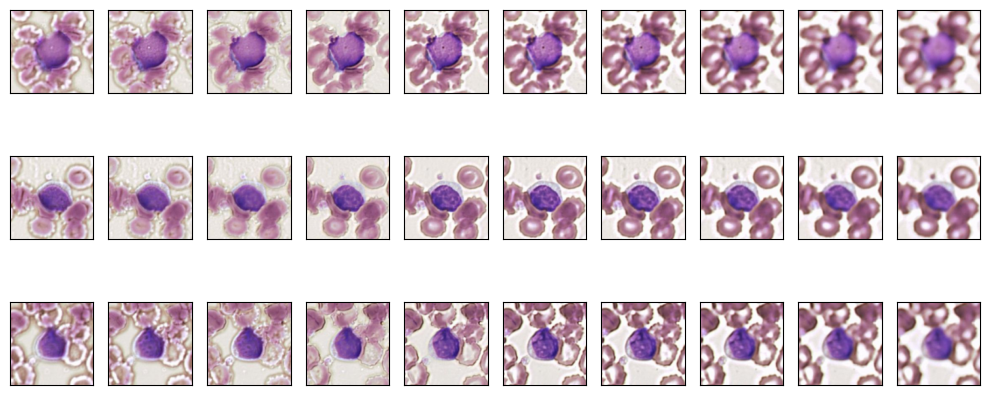

In [15]:
plt.figure(figsize=(10,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x3[i] * 255).astype(np.uint8))
plt.show()

In [12]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    return x

def DenseNet5(input_shape=(128, 128, 3), num_classes=5):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model
    
#new_model = DenseNet5()

In [13]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    return x

def DenseNet8(input_shape=(128, 128, 3), num_classes=8):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model
    
#new_model = DenseNet8()

In [14]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    return x

def DenseNet16(input_shape=(128, 128, 3), num_classes=16):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

#model = DenseNet121()
#model.summary()

In [15]:
def get_final_dense_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Dense):
            return layer
    raise ValueError("No Dense layer found in the model.")
    
#########################################################################################
y_train_int2 = np.argmax(y_train_encoded2, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int2),
    y=y_train_int2
)
class_weights_dict2 = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights_raabin:", class_weights_dict2)

y_train_int3 = np.argmax(y_train_encoded3, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int3),
    y=y_train_int3
)
class_weights_dict3 = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights_pbc:", class_weights_dict3)


### federated Learning full model aggregation ###
 ## 3 models for 3 clients ##
model1 = DenseNet16()
model2 = DenseNet5()
model3 = DenseNet8()
model4 = DenseNet16()
################################################################
# LR = 0.001
# lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR, decay_steps=1000, decay_rate=0.1) #should be < 1, or lr rate increa
# optim = optimizers.Adam(learning_rate=lr_schedule)

filepath1 = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint1 = ModelCheckpoint(filepath=filepath1, monitor='loss',verbose=1, save_best_only=False,mode='min')

filepath2 = '/mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint2 = ModelCheckpoint(filepath=filepath2, monitor='loss',verbose=1, save_best_only=False, mode='min')

filepath3 = '/mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint3 = ModelCheckpoint(filepath=filepath3, monitor='loss',verbose=1, save_best_only=False, mode='min')

model1.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

  ###training 3 models for 3 clients
for i in tqdm(range(110)):
    #print("Starting client 1 training")
    
    model1.fit(x1, y1_encoded, epochs=2, batch_size=40, verbose=1, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint1]) 
    model2.fit(x_train_augmented2, y_train_encoded2, epochs=2, batch_size=40, verbose=1, validation_data=(x_test2, y_test_encoded2), callbacks=[checkpoint2],class_weight=class_weights_dict2)
    model3.fit(x_train_augmented3, y_train_encoded3, epochs=2, batch_size=40, verbose=1, validation_data=(x_test3, y_test_encoded3), callbacks=[checkpoint3],class_weight=class_weights_dict3)
    model4.fit(x2, y2_encoded, epochs=2, batch_size=40, verbose=1, validation_data=None) 

    # Step 1: Identify the final Dense layer for each model
    final_layer1 = get_final_dense_layer(model1)
    final_layer2 = get_final_dense_layer(model2)
    final_layer3 = get_final_dense_layer(model3)
    final_layer4 = get_final_dense_layer(model4)

    # Step 2: Calculate the mean of the weights for layers excluding the final Dense layer
    mean_weights = {}
    for i, (layer1, layer2, layer3, layer4) in enumerate(zip(model1.layers, model2.layers, model3.layers, model4.layers)):
        # Skip the final Dense layers
        if layer1 == final_layer1 or layer2 == final_layer2 or layer3 == final_layer3 or layer4 == final_layer4:
            continue
    
        # Get weights for corresponding layers
        weights1 = layer1.get_weights()
        weights2 = layer2.get_weights()
        weights3 = layer3.get_weights()
        weights4 = layer4.get_weights()
    
        # Compute the mean for each weight and bias
        if weights1 and weights2 and weights3 and weights4:   # Check if the layer has weights
            mean_weights[i] = [np.mean([w1, w2, w3, w4], axis=0) for w1, w2, w3 , w4 in zip(weights1, weights2, weights3, weights4)]
    
        # Step 3: Apply the mean weights to both models
    for i, (layer1, layer2, layer3, layer4) in enumerate(zip(model1.layers, model2.layers, model3.layers, model4.layers)):
        # Skip the final Dense layers
        if layer1 == final_layer1 or layer2 == final_layer2 or layer3 == final_layer3 or layer4 == final_layer4:
            continue
    
        if i in mean_weights:
            layer1.set_weights(mean_weights[i])
            layer2.set_weights(mean_weights[i])
            layer3.set_weights(mean_weights[i])
            layer4.set_weights(mean_weights[i])
            
        # Verify the update
    print("All models have been updated with the mean weights (excluding the final Dense layer).") 

print("/n/n Done with federated training")

Class Weights_raabin: {0: 2.7839622641509436, 1: 1.3221326164874552, 2: 1.215904408735064, 3: 1.0520499108734402, 4: 0.4735997432193869}
Class Weights_pbc: {0: 1.7546948356807512, 1: 0.6854653828519028, 2: 1.3778801843317972, 3: 0.7379072063178678, 4: 1.7608951707891638, 5: 1.5040241448692153, 6: 0.6416309012875536, 7: 0.9099208764455264}


I0000 00:00:1734316334.878111    8616 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734316335.063930    8616 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734316335.064023    8616 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734316335.075139    8616 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734316335.075232    8616 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/2


I0000 00:00:1734316407.752155    8867 service.cc:146] XLA service 0x7f1f000026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734316407.752208    8867 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-12-15 20:33:29.048639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-15 20:33:34.735685: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-15 20:34:53.131326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_68', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734316493.631894    8867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6589 - loss: 1.1008

2024-12-15 20:38:26.829290: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2024-12-15 20:38:27.404271: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 172 bytes spill stores, 172 bytes spill loads

2024-12-15 20:38:32.953796: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2024-12-15 20:38:33.734256: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 172 bytes spill stores, 172 bytes spill loads




Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.513-loss_1.478.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 357s 81ms/step - accuracy: 0.6589 - loss: 1.1007 - val_accuracy: 0.5129 - val_loss: 1.4778
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8085 - loss: 0.4957
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.440-loss_1.688.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 205s 71ms/step - accuracy: 0.8085 - loss: 0.4957 - val_accuracy: 0.4400 - val_loss: 1.6879
Epoch 1/2


2024-12-15 20:44:06.186375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_56', 8 bytes spill stores, 8 bytes spill loads



368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6201 - loss: 1.3386

2024-12-15 20:45:56.432090: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_48', 8 bytes spill stores, 8 bytes spill loads



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6205 - loss: 1.3369

2024-12-15 20:46:01.819480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2024-12-15 20:46:02.177716: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2024-12-15 20:46:02.219991: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 236 bytes spill stores, 236 bytes spill loads

2024-12-15 20:46:11.335834: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2024-12-15 20:46:11.414786: I external/local_xla/xla/stream_exec


Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.201-loss_3.393.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 248s 360ms/step - accuracy: 0.6209 - loss: 1.3352 - val_accuracy: 0.2015 - val_loss: 3.3930
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9150 - loss: 0.2587
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.379-loss_4.992.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9150 - loss: 0.2587 - val_accuracy: 0.3791 - val_loss: 4.9923
Epoch 1/2


2024-12-15 20:48:57.270648: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_68', 8 bytes spill stores, 8 bytes spill loads



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7570 - loss: 0.7454

2024-12-15 20:52:09.725558: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 8 bytes spill stores, 8 bytes spill loads

2024-12-15 20:52:10.110729: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 180 bytes spill stores, 180 bytes spill loads




Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.852-loss_0.862.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 320s 78ms/step - accuracy: 0.7570 - loss: 0.7453 - val_accuracy: 0.8515 - val_loss: 0.8621
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9370 - loss: 0.1884
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.530-loss_2.755.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 180s 67ms/step - accuracy: 0.9370 - loss: 0.1884 - val_accuracy: 0.5302 - val_loss: 2.7552
Epoch 1/2


2024-12-15 20:57:34.249313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_68', 8 bytes spill stores, 8 bytes spill loads



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 272s 55ms/step - accuracy: 0.6433 - loss: 1.1561
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 155s 54ms/step - accuracy: 0.8101 - loss: 0.4942


  1%|▋                                                                             | 1/110 [31:10<56:37:47, 1870.35s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6760 - loss: 0.9956
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.359-loss_2.664.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - accuracy: 0.6760 - loss: 0.9955 - val_accuracy: 0.3592 - val_loss: 2.6640
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8198 - loss: 0.4615
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.115-loss_12.940.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 206s 72ms/step - accuracy: 0.8198 - loss: 0.4615 - val_accuracy: 0.1153 - val_loss: 12.9400
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7523 - loss: 0.5996
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.410-loss_3.975.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.7526 - loss: 0.5989 - val_

  2%|█▍                                                                            | 2/110 [51:16<44:23:42, 1479.84s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7754 - loss: 0.6272
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.353-loss_4.325.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 214s 75ms/step - accuracy: 0.7755 - loss: 0.6272 - val_accuracy: 0.3529 - val_loss: 4.3245
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8470 - loss: 0.3838
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.484-loss_2.083.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - accuracy: 0.8470 - loss: 0.3838 - val_accuracy: 0.4839 - val_loss: 2.0826
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8467 - loss: 0.4252
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.713-loss_1.119.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.8469 - loss: 0.4247 - val_ac

  3%|██                                                                          | 3/110 [1:12:01<40:47:30, 1372.43s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8196 - loss: 0.4673
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.685-loss_0.940.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 203s 71ms/step - accuracy: 0.8196 - loss: 0.4673 - val_accuracy: 0.6855 - val_loss: 0.9396
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8674 - loss: 0.3289
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.714-loss_0.947.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 211s 74ms/step - accuracy: 0.8674 - loss: 0.3289 - val_accuracy: 0.7137 - val_loss: 0.9470
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9073 - loss: 0.2852
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.627-loss_1.565.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.9074 - loss: 0.2849 - val_ac

  4%|██▊                                                                         | 4/110 [1:32:49<38:57:52, 1323.32s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8451 - loss: 0.3851
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.454-loss_2.677.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 199s 69ms/step - accuracy: 0.8451 - loss: 0.3851 - val_accuracy: 0.4541 - val_loss: 2.6773
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8854 - loss: 0.2854
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.742-loss_0.789.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 201s 70ms/step - accuracy: 0.8854 - loss: 0.2854 - val_accuracy: 0.7420 - val_loss: 0.7889
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9443 - loss: 0.1790
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.779-loss_0.850.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.9443 - loss: 0.1788 - val_ac

  5%|███▍                                                                        | 5/110 [1:53:44<37:52:46, 1298.73s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8678 - loss: 0.3269
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.693-loss_1.149.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 197s 69ms/step - accuracy: 0.8678 - loss: 0.3269 - val_accuracy: 0.6933 - val_loss: 1.1491
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9052 - loss: 0.2389
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.439-loss_4.723.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9052 - loss: 0.2389 - val_accuracy: 0.4392 - val_loss: 4.7226
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9511 - loss: 0.1489
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.708-loss_1.725.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.9511 - loss: 0.1488 - val_ac

  5%|████▏                                                                       | 6/110 [2:13:35<36:27:31, 1262.03s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8912 - loss: 0.2713
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.795-loss_0.577.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 198s 69ms/step - accuracy: 0.8912 - loss: 0.2713 - val_accuracy: 0.7945 - val_loss: 0.5767
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9272 - loss: 0.1920
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.581-loss_1.795.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 207s 72ms/step - accuracy: 0.9272 - loss: 0.1920 - val_accuracy: 0.5812 - val_loss: 1.7948
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9606 - loss: 0.1134
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.761-loss_0.821.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.9607 - loss: 0.1133 - val_ac

  6%|████▊                                                                       | 7/110 [2:33:31<35:29:14, 1240.33s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9156 - loss: 0.2202
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.653-loss_1.341.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9156 - loss: 0.2202 - val_accuracy: 0.6525 - val_loss: 1.3414
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9450 - loss: 0.1498
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.780-loss_0.813.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 172s 60ms/step - accuracy: 0.9450 - loss: 0.1498 - val_accuracy: 0.7796 - val_loss: 0.8128
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9602 - loss: 0.1108
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.611-loss_2.004.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.9602 - loss: 0.1107 - val_ac

  7%|█████▌                                                                      | 8/110 [2:51:48<33:51:14, 1194.85s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9355 - loss: 0.1673
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.747-loss_1.026.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.9355 - loss: 0.1673 - val_accuracy: 0.7475 - val_loss: 1.0261
Epoch 2/2
2858/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9594 - loss: 0.1116
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.774-loss_0.966.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9594 - loss: 0.1116 - val_accuracy: 0.7741 - val_loss: 0.9658
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9587 - loss: 0.1045
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.765-loss_0.989.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9587 - loss: 0.1044 - val_ac

  8%|██████▏                                                                     | 9/110 [3:10:22<32:48:48, 1169.59s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9566 - loss: 0.1185
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.795-loss_0.800.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 177s 62ms/step - accuracy: 0.9566 - loss: 0.1185 - val_accuracy: 0.7945 - val_loss: 0.7997
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9671 - loss: 0.0921
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.795-loss_1.207.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 61ms/step - accuracy: 0.9671 - loss: 0.0921 - val_accuracy: 0.7945 - val_loss: 1.2069
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9662 - loss: 0.0884
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.762-loss_1.978.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9663 - loss: 0.0883 - val_ac

  9%|██████▊                                                                    | 10/110 [3:28:30<31:47:04, 1144.25s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9658 - loss: 0.0961
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.831-loss_0.895.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 175s 61ms/step - accuracy: 0.9658 - loss: 0.0961 - val_accuracy: 0.8306 - val_loss: 0.8947
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9751 - loss: 0.0722
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.733-loss_1.359.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 192s 67ms/step - accuracy: 0.9751 - loss: 0.0722 - val_accuracy: 0.7333 - val_loss: 1.3592
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9703 - loss: 0.0889
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.640-loss_2.280.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9703 - loss: 0.0888 - val_ac

 10%|███████▌                                                                   | 11/110 [3:46:56<31:08:43, 1132.56s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9730 - loss: 0.0765
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.815-loss_1.035.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 173s 60ms/step - accuracy: 0.9730 - loss: 0.0765 - val_accuracy: 0.8149 - val_loss: 1.0349
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9759 - loss: 0.0681
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.761-loss_1.206.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9759 - loss: 0.0681 - val_accuracy: 0.7608 - val_loss: 1.2058
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9675 - loss: 0.0850
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.793-loss_1.055.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9676 - loss: 0.0849 - val_ac

 11%|████████▏                                                                  | 12/110 [4:05:17<30:34:35, 1123.22s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9764 - loss: 0.0659
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.045-loss_58.099.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9764 - loss: 0.0659 - val_accuracy: 0.0447 - val_loss: 58.0994
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9733 - loss: 0.0773
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.792-loss_1.087.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 64ms/step - accuracy: 0.9733 - loss: 0.0773 - val_accuracy: 0.7922 - val_loss: 1.0873
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9717 - loss: 0.0851
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.659-loss_2.158.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9717 - loss: 0.0850 - val_

 12%|████████▊                                                                  | 13/110 [4:24:16<30:23:16, 1127.80s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9830 - loss: 0.0497
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.826-loss_0.910.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 195s 68ms/step - accuracy: 0.9830 - loss: 0.0497 - val_accuracy: 0.8259 - val_loss: 0.9104
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9818 - loss: 0.0529
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.815-loss_1.018.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 189s 66ms/step - accuracy: 0.9818 - loss: 0.0529 - val_accuracy: 0.8149 - val_loss: 1.0180
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9734 - loss: 0.0695
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.797-loss_0.863.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9735 - loss: 0.0694 - val_ac

 13%|█████████▌                                                                 | 14/110 [4:43:06<30:05:32, 1128.47s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9849 - loss: 0.0418
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.779-loss_1.546.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9849 - loss: 0.0418 - val_accuracy: 0.7788 - val_loss: 1.5460
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9840 - loss: 0.0463
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.715-loss_1.666.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9839 - loss: 0.0463 - val_accuracy: 0.7153 - val_loss: 1.6660
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9749 - loss: 0.0670
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.748-loss_1.070.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.9749 - loss: 0.0669 - val_ac

 14%|██████████▏                                                                | 15/110 [5:01:19<29:30:00, 1117.90s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9871 - loss: 0.0383
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.787-loss_1.324.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.9871 - loss: 0.0383 - val_accuracy: 0.7867 - val_loss: 1.3245
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9834 - loss: 0.0493
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.824-loss_1.276.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 181s 63ms/step - accuracy: 0.9834 - loss: 0.0493 - val_accuracy: 0.8243 - val_loss: 1.2762
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9800 - loss: 0.0507
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.751-loss_2.726.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.9800 - loss: 0.0506 - val_ac

 15%|██████████▉                                                                | 16/110 [5:19:46<29:06:17, 1114.66s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9911 - loss: 0.0268
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.806-loss_1.228.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 169s 59ms/step - accuracy: 0.9911 - loss: 0.0268 - val_accuracy: 0.8063 - val_loss: 1.2277
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9863 - loss: 0.0406
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.811-loss_1.357.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 169s 59ms/step - accuracy: 0.9863 - loss: 0.0406 - val_accuracy: 0.8110 - val_loss: 1.3572
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9742 - loss: 0.0597
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.650-loss_4.103.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9743 - loss: 0.0596 - val_ac

 15%|███████████▌                                                               | 17/110 [5:37:45<28:30:44, 1103.70s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9882 - loss: 0.0352
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.661-loss_2.288.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9882 - loss: 0.0352 - val_accuracy: 0.6612 - val_loss: 2.2879
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9853 - loss: 0.0453
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.796-loss_1.621.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 175s 61ms/step - accuracy: 0.9853 - loss: 0.0453 - val_accuracy: 0.7961 - val_loss: 1.6213
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9816 - loss: 0.0493
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.812-loss_1.579.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9816 - loss: 0.0493 - val_ac

 16%|████████████▎                                                              | 18/110 [5:56:12<28:13:57, 1104.76s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9914 - loss: 0.0268
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.792-loss_1.970.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 181s 63ms/step - accuracy: 0.9914 - loss: 0.0268 - val_accuracy: 0.7922 - val_loss: 1.9704
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9873 - loss: 0.0379
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_1.093.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9873 - loss: 0.0379 - val_accuracy: 0.8267 - val_loss: 1.0930
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9815 - loss: 0.0535
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.776-loss_1.233.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9815 - loss: 0.0535 - val_ac

 17%|████████████▉                                                              | 19/110 [6:14:38<27:56:06, 1105.13s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9950 - loss: 0.0154
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.818-loss_1.320.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 174s 61ms/step - accuracy: 0.9950 - loss: 0.0154 - val_accuracy: 0.8180 - val_loss: 1.3198
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9888 - loss: 0.0337
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.705-loss_2.211.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9888 - loss: 0.0337 - val_accuracy: 0.7051 - val_loss: 2.2113
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9802 - loss: 0.0563
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.715-loss_2.408.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9803 - loss: 0.0562 - val_ac

 18%|█████████████▋                                                             | 20/110 [6:32:49<27:31:21, 1100.90s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9921 - loss: 0.0234
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.796-loss_1.340.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 184s 64ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.7961 - val_loss: 1.3396
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9872 - loss: 0.0380
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.720-loss_2.044.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9872 - loss: 0.0380 - val_accuracy: 0.7200 - val_loss: 2.0442
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9828 - loss: 0.0414
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.833-loss_1.037.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9828 - loss: 0.0413 - val_ac

 19%|██████████████▎                                                            | 21/110 [6:51:23<27:18:55, 1104.89s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9943 - loss: 0.0180
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.774-loss_1.657.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.7741 - val_loss: 1.6566
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9897 - loss: 0.0317
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.813-loss_1.243.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9897 - loss: 0.0317 - val_accuracy: 0.8133 - val_loss: 1.2430
Epoch 1/2
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9792 - loss: 0.0507
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.689-loss_2.868.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9793 - loss: 0.0506 - val_ac

 20%|███████████████                                                            | 22/110 [7:10:00<27:05:45, 1108.48s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9939 - loss: 0.0191
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.834-loss_1.221.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 187s 65ms/step - accuracy: 0.9939 - loss: 0.0191 - val_accuracy: 0.8337 - val_loss: 1.2208
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9888 - loss: 0.0342
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.831-loss_1.266.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 64ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accuracy: 0.8314 - val_loss: 1.2662
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9804 - loss: 0.0457
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.747-loss_1.467.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.9804 - loss: 0.0456 - val_ac

 21%|███████████████▋                                                           | 23/110 [7:28:38<26:51:41, 1111.51s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9934 - loss: 0.0201
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.819-loss_1.177.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9934 - loss: 0.0201 - val_accuracy: 0.8188 - val_loss: 1.1771
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 179s 67ms/step - accuracy: 0.9897 - loss: 0.0292 - val_accuracy: 0.9762 - val_loss: 0.1303
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9943 - loss: 0.0168
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.964-loss_0.263.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 173s 64ms/step - accuracy: 0.9943 - loss: 0.0168 - val_accuracy: 0.9640 - val_loss: 0.2630
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.9947 - loss: 0.0160
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 150s 53ms/step -

 22%|████████████████▎                                                          | 24/110 [7:47:20<26:37:22, 1114.45s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9942 - loss: 0.0176
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.740-loss_2.008.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 189s 66ms/step - accuracy: 0.9942 - loss: 0.0176 - val_accuracy: 0.7396 - val_loss: 2.0085
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9903 - loss: 0.0305
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.799-loss_1.343.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9903 - loss: 0.0305 - val_accuracy: 0.7992 - val_loss: 1.3426
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9850 - loss: 0.0334
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.815-loss_1.020.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9850 - loss: 0.0334 - val_ac

 23%|█████████████████                                                          | 25/110 [8:06:10<26:25:31, 1119.19s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9943 - loss: 0.0183
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.802-loss_1.725.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 181s 63ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.8016 - val_loss: 1.7247
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9910 - loss: 0.0279
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_1.395.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.9910 - loss: 0.0279 - val_accuracy: 0.8275 - val_loss: 1.3949
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9858 - loss: 0.0398
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.780-loss_1.187.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 146s 51ms/step - accuracy: 0.9895 - loss: 0.0320


 24%|█████████████████▋                                                         | 26/110 [8:24:34<26:00:20, 1114.53s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9961 - loss: 0.0121
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.826-loss_1.362.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 187s 66ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.8259 - val_loss: 1.3619
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9905 - loss: 0.0298
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.775-loss_2.084.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9905 - loss: 0.0298 - val_accuracy: 0.7749 - val_loss: 2.0837
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9834 - loss: 0.0368
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.710-loss_2.494.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9834 - loss: 0.0368 - val_ac

 25%|██████████████████▍                                                        | 27/110 [8:42:43<25:31:29, 1107.10s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9953 - loss: 0.0162
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.807-loss_2.008.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 173s 60ms/step - accuracy: 0.9953 - loss: 0.0162 - val_accuracy: 0.8071 - val_loss: 2.0080
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.9909 - loss: 0.0290


 25%|███████████████████                                                        | 28/110 [9:00:56<25:07:01, 1102.71s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9966 - loss: 0.0106
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.617-loss_3.451.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 172s 60ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.6173 - val_loss: 3.4512
Epoch 2/2
2858/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9879 - loss: 0.0409
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.838-loss_1.599.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 172s 60ms/step - accuracy: 0.9879 - loss: 0.0409 - val_accuracy: 0.8384 - val_loss: 1.5994
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9841 - loss: 0.0473
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.688-loss_2.631.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9841 - loss: 0.0473 - val_ac

 29%|█████████████████████▌                                                    | 32/110 [10:18:03<25:13:29, 1164.22s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9975 - loss: 0.0079
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.794-loss_2.181.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 187s 65ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.7937 - val_loss: 2.1808
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9963 - loss: 0.0126
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_1.410.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.8157 - val_loss: 1.4097
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9948 - loss: 0.0166
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.784-loss_1.859.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9948 - loss: 0.0166 - val_accur

 31%|██████████████████████▊                                                   | 34/110 [10:54:37<23:50:04, 1129.00s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9974 - loss: 0.0092
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_1.425.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.8275 - val_loss: 1.4246
Epoch 2/2
1871/2859 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.9936 - loss: 0.0212Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9838 - loss: 0.0459
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.774-loss_2.571.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9838 - loss: 0.0459 - val_accuracy: 0.7736 - val_loss: 2.5709
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9935 - loss: 0.0147
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.579-loss_4.700.

 32%|███████████████████████▌                                                  | 35/110 [11:12:57<23:20:15, 1120.20s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9959 - loss: 0.0138
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.968-loss_0.193.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 170s 63ms/step - accuracy: 0.9959 - loss: 0.0138 - val_accuracy: 0.9678 - val_loss: 0.1932
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 139s 48ms/step - accuracy: 0.9983 - loss: 0.0058
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9982 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_1.436.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.8157 - val_loss: 1.4359
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9941 - loss: 0.0201
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.799-loss_2.000.ke

 35%|█████████████████████████▌                                                | 38/110 [12:07:24<21:58:55, 1099.11s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9969 - loss: 0.0110
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_2.438.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9969 - loss: 0.0110 - val_accuracy: 0.8157 - val_loss: 2.4375
Epoch 2/2
1249/2859 ━━━━━━━━━━━━━━━━━━━━ 1:42 64ms/step - accuracy: 0.9945 - loss: 0.0169
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.718-loss_1.859.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9948 - loss: 0.0228 - val_accuracy: 0.7182 - val_loss: 1.8587
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.9977 - loss: 0.0073
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 139s 49ms/step - accuracy: 0.9938 - loss: 0.0223


 35%|██████████████████████████▏                                               | 39/110 [12:25:52<21:44:02, 1102.00s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9982 - loss: 0.0066
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.818-loss_2.133.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.8180 - val_loss: 2.1332
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9943 - loss: 0.0191
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.818-loss_1.817.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9943 - loss: 0.0191 - val_accuracy: 0.8180 - val_loss: 1.8168
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9921 - loss: 0.0195
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.795-loss_1.399.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.9921 - loss: 0.0195 - val_ac

 36%|██████████████████████████▉                                               | 40/110 [12:44:10<21:24:10, 1100.73s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9939 - loss: 0.0202
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.831-loss_2.987.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.8306 - val_loss: 2.9868
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9929 - loss: 0.0191
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.712-loss_1.979.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9929 - loss: 0.0190 - val_accuracy: 0.7117 - val_loss: 1.9795
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9981 - loss: 0.0065
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.839-loss_1.082.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - accuracy: 0.9981 - loss: 0.0065 - val

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9945 - loss: 0.0178
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.898-loss_0.852.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 171s 63ms/step - accuracy: 0.9945 - loss: 0.0178 - val_accuracy: 0.8979 - val_loss: 0.8521
Epoch 2/2
2544/2691 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9963 - loss: 0.0120Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9947 - loss: 0.0183
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.847-loss_1.790.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 161s 56ms/step - accuracy: 0.9947 - loss: 0.0183 - val_accuracy: 0.8471 - val_loss: 1.7903
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9881 - loss: 0.0302
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.674-loss_3.541.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9881 - loss: 0.0302 - val_accura

 38%|████████████████████████████▎                                             | 42/110 [13:19:51<20:27:43, 1083.28s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9985 - loss: 0.0058
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.791-loss_2.307.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 190s 66ms/step - accuracy: 0.9985 - loss: 0.0058 - val_accuracy: 0.7906 - val_loss: 2.3067
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9933 - loss: 0.0241
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.458-loss_9.548.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9933 - loss: 0.0241 - val_accuracy: 0.4580 - val_loss: 9.5478
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9913 - loss: 0.0205
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.833-loss_0.842.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9914 - loss: 0.0205 - val_ac

 39%|████████████████████████████▉                                             | 43/110 [13:38:09<20:14:44, 1087.82s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9976 - loss: 0.0086
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.795-loss_2.488.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9976 - loss: 0.0086 - val_accuracy: 0.7945 - val_loss: 2.4883
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9967 - loss: 0.0097
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.936-loss_0.474.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 168s 62ms/step - accuracy: 0.9967 - loss: 0.0097 - val_accuracy: 0.9361 - val_loss: 0.4739
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9976 - loss: 0.0077
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 0.9927 - loss: 0.0282


 40%|█████████████████████████████▌                                            | 44/110 [13:55:57<19:50:03, 1081.87s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9984 - loss: 0.0062
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.762-loss_2.403.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 177s 62ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.7624 - val_loss: 2.4032
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9940 - loss: 0.0212
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.715-loss_2.338.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 168s 59ms/step - accuracy: 0.9940 - loss: 0.0212 - val_accuracy: 0.7153 - val_loss: 2.3379
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9962 - loss: 0.0117
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.978-loss_0.251.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 173s 64ms/step - accuracy: 0.9962 - loss: 0.0117 - val_

 43%|███████████████████████████████▌                                          | 47/110 [14:51:01<19:10:34, 1095.78s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
1994/2859 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - accuracy: 0.9949 - loss: 0.0171Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - accuracy: 0.9982 - loss: 0.0066
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9945 - loss: 0.0199
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.697-loss_3.637.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 186s 65ms/step - accuracy: 0.9945 - loss: 0.0199 - val_accuracy: 0.6973 - val_loss: 3.6366
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9973 - loss: 0.0087
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.974-loss_0.234.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 166s 62ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9745 - val_loss: 0.2338
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9950 - loss: 0.0182


 45%|████████████████████████████████▉                                         | 49/110 [15:27:52<18:38:47, 1100.45s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9988 - loss: 0.0046
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.762-loss_2.888.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 194s 68ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.7616 - val_loss: 2.8882
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9953 - loss: 0.0171
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.835-loss_1.968.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.8345 - val_loss: 1.9682
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9945 - loss: 0.0126
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.808-loss_1.771.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9945 - loss: 0.0126 - val_ac

 45%|█████████████████████████████████▋                                        | 50/110 [15:46:32<18:26:25, 1106.43s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9990 - loss: 0.0041
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.819-loss_2.154.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 195s 68ms/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.8188 - val_loss: 2.1541
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9939 - loss: 0.0171
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.682-loss_2.496.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9939 - loss: 0.0170 - val_accuracy: 0.6824 - val_loss: 2.4964
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - accuracy: 0.9985 - loss: 0.0058
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9954 - loss: 0.0155
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.718-loss_2.969.kera

 47%|██████████████████████████████████▉                                       | 52/110 [16:23:32<17:50:23, 1107.30s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9991 - loss: 0.0041
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.824-loss_1.943.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 181s 63ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.8243 - val_loss: 1.9427
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9951 - loss: 0.0198
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.821-loss_2.391.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 190s 66ms/step - accuracy: 0.9951 - loss: 0.0198 - val_accuracy: 0.8212 - val_loss: 2.3907
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9940 - loss: 0.0129
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.721-loss_5.122.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9940 - loss: 0.0129 - val_ac

 48%|███████████████████████████████████▋                                      | 53/110 [16:41:52<17:29:47, 1105.04s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9975 - loss: 0.0078
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.973-loss_0.214.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 167s 62ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accuracy: 0.9731 - val_loss: 0.2137
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9990 - loss: 0.0035
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.804-loss_2.105.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 175s 61ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.8039 - val_loss: 2.1049
Epoch 2/2
 599/2859 ━━━━━━━━━━━━━━━━━━━━ 2:15 60ms/step - accuracy: 0.9968 - loss: 0.0111Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9957 - loss: 0.0122
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.697-loss_2.6

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9943 - loss: 0.0191
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.651-loss_4.293.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.9943 - loss: 0.0191 - val_accuracy: 0.6514 - val_loss: 4.2932
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - accuracy: 0.9996 - loss: 0.0012
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9951 - loss: 0.0211
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.824-loss_2.240.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9951 - loss: 0.0211 - val_accuracy: 0.8243 - val_loss: 2.2400
Epoch 1/2
2690/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9970 - loss: 0.0099
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.978-loss_0.206.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 158s 59ms/step - accuracy: 0.9970 - loss: 0.0099 - val_acc

 54%|███████████████████████████████████████▋                                  | 59/110 [18:29:56<15:22:22, 1085.15s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9990 - loss: 0.0040
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.787-loss_2.610.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 177s 62ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.7875 - val_loss: 2.6101
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9973 - loss: 0.0083
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.736-loss_2.397.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.9973 - loss: 0.0083 - val_accuracy: 0.7361 - val_loss: 2.3969
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 144s 50ms/step - accuracy: 0.9988 - loss: 0.0051
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9962 - loss: 0.0137
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.785-loss_2.643.kera

 55%|█████████████████████████████████████████                                 | 61/110 [19:06:34<14:53:11, 1093.71s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9992 - loss: 0.0029
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.796-loss_2.721.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.7961 - val_loss: 2.7208
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9941 - loss: 0.0134
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.750-loss_2.407.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9941 - loss: 0.0134 - val_accuracy: 0.7498 - val_loss: 2.4068
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9977 - loss: 0.0051
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.650-loss_3.834.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9977 - loss: 0.0051 - val

 56%|█████████████████████████████████████████▋                                | 62/110 [19:25:11<14:40:44, 1100.93s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9981 - loss: 0.0071
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.967-loss_0.279.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 169s 63ms/step - accuracy: 0.9981 - loss: 0.0071 - val_accuracy: 0.9671 - val_loss: 0.2791
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9991 - loss: 0.0035
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.798-loss_2.537.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 64ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.7984 - val_loss: 2.5372
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9952 - loss: 0.0195
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.776-loss_2.739.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.9952 - loss: 0.0195 - val_

 58%|███████████████████████████████████████████                               | 64/110 [20:01:54<14:05:28, 1102.79s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - accuracy: 0.9994 - loss: 0.0023
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9962 - loss: 0.0149
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.798-loss_3.834.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 174s 61ms/step - accuracy: 0.9962 - loss: 0.0149 - val_accuracy: 0.7984 - val_loss: 3.8342
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9958 - loss: 0.0116
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.834-loss_1.316.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9958 - loss: 0.0116 - val_accuracy: 0.8343 - val_loss: 1.3161
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9974 - loss: 0.0057
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.787-loss_1.67

 60%|████████████████████████████████████████████▍                             | 66/110 [20:38:12<13:23:15, 1095.36s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9983 - loss: 0.0060
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.976-loss_0.257.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 170s 63ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9756 - val_loss: 0.2569
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9960 - loss: 0.0192
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.819-loss_2.094.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 193s 68ms/step - accuracy: 0.9960 - loss: 0.0192 - val_accuracy: 0.8188 - val_loss: 2.0937
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9937 - loss: 0.0202
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.734-loss_2.369.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9937 - loss: 0.0202 - v

 62%|█████████████████████████████████████████████▋                            | 68/110 [21:15:12<12:52:35, 1103.71s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9992 - loss: 0.0035
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_2.635.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 190s 66ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.8165 - val_loss: 2.6352
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9984 - loss: 0.0040
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.849-loss_1.072.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9984 - loss: 0.0040 - val_accuracy: 0.8489 - val_loss: 1.0718
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - accuracy: 0.9994 - loss: 0.0023
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9964 - loss: 0.0149
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.778-loss_3.037.kera

 64%|███████████████████████████████████████████████                           | 70/110 [21:52:12<12:18:04, 1107.10s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9991 - loss: 0.0034
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_2.192.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.8267 - val_loss: 2.1917
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9972 - loss: 0.0053
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.710-loss_4.212.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9972 - loss: 0.0053 - val_accuracy: 0.7095 - val_loss: 4.2124
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 149s 52ms/step - accuracy: 0.9994 - loss: 0.0027
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9956 - loss: 0.0192
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.798-loss_2.783.kera

 65%|████████████████████████████████████████████████▍                         | 72/110 [22:28:58<11:39:47, 1104.94s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9986 - loss: 0.0063
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.835-loss_2.034.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 184s 64ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.8353 - val_loss: 2.0342
Epoch 2/2
 921/2859 ━━━━━━━━━━━━━━━━━━━━ 2:09 67ms/step - accuracy: 0.9970 - loss: 0.0128
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.797-loss_1.795.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.9961 - loss: 0.0080 - val_accuracy: 0.7972 - val_loss: 1.7949
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.751-loss_2.539.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.9994 - loss: 0.0021 -

 67%|█████████████████████████████████████████████████▊                        | 74/110 [23:05:19<10:58:05, 1096.81s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9993 - loss: 0.0027
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.802-loss_3.267.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 185s 65ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.8024 - val_loss: 3.2665
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9991 - loss: 0.0025024
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.669-loss_3.042.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.6691 - val_loss: 3.0420
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9978 - loss: 0.0076
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.984-loss_0.232.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 172s 64ms/step - accuracy: 0.9978 - loss: 0.0076 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.9961 - loss: 0.0173


 69%|███████████████████████████████████████████████████▏                      | 76/110 [23:41:54<10:21:48, 1097.31s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9991 - loss: 0.0034
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9980 - loss: 0.0064
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.960-loss_0.515.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 176s 65ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9604 - val_loss: 0.5146
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9980 - loss: 0.0051
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.985-loss_0.154.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 177s 66ms/step - accuracy: 0.9980 - loss: 0.0051 - val_accuracy: 0.9852 - val_loss: 0.1539
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9988 - loss: 0.0076
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.799-loss_3.3

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 0.9966 - loss: 0.0159


 72%|█████████████████████████████████████████████████████▊                     | 79/110 [24:36:28<9:24:26, 1092.48s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9993 - loss: 0.0028
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.820-loss_3.576.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 187s 65ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.8204 - val_loss: 3.5759
Epoch 2/2
1392/2859 ━━━━━━━━━━━━━━━━━━━━ 1:32 63ms/step - accuracy: 0.9956 - loss: 0.0201

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1762/2691 ━━━━━━━━━━━━━━━━━━━━ 1:00 65ms/step - accuracy: 0.9978 - loss: 0.0103Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 135s 47ms/step - accuracy: 0.9999 - loss: 3.2980e-04
Epoch 2/2
1889/2859 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.9938 - loss: 0.0332

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9976 - loss: 0.0051
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.650-loss_4.291.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9976 - loss: 0.0051 - val_accuracy: 0.6504 - val_loss: 4.2908
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9980 - loss: 0.0058
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.754-loss_2.064.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.7543 - val_loss: 2.0639
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9984 - loss: 0.0052
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.986-loss_0.216.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 166s 62ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9864 - val_loss: 0.2160
Epoch 2/2
 217/2691 ━━━━━━━━━━━━━━━━━━━━ 2:33 62ms/ste

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1706/2859 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step - accuracy: 0.9965 - loss: 0.0156Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9997 - loss: 0.0015
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.802-loss_2.812.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.8024 - val_loss: 2.8115
Epoch 2/2
 387/2859 ━━━━━━━━━━━━━━━━━━━━ 2:28 60ms/step - accuracy: 0.9948 - loss: 0.0206

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9978 - loss: 0.0078
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.912-loss_0.767.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 176s 65ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9115 - val_loss: 0.7667
Epoch 1/2
2613/2859 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9996 - loss: 0.0015

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9954 - loss: 0.0124 - val_accuracy: 0.7476 - val_loss: 2.4145
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9978 - loss: 0.0059
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.796-loss_1.555.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9978 - loss: 0.0059 - val_accuracy: 0.7962 - val_loss: 1.5554
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9987 - loss: 0.0036
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.975-loss_0.245.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 169s 63ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.9751 - val_loss: 0.2454
Epoch 2/2
 153/2691 ━━━━━━━━━━━━━━━━━━━━ 2:53 68ms/step - accuracy: 0.9985 - loss: 0.0052

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1711/2859 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step - accuracy: 0.9982 - loss: 0.0103Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9994 - loss: 0.0027
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.830-loss_2.739.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.8298 - val_loss: 2.7394
Epoch 2/2
 283/2859 ━━━━━━━━━━━━━━━━━━━━ 2:32 59ms/step - accuracy: 0.9961 - loss: 0.0145

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.965-loss_0.322.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 165s 61ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 0.9647 - val_loss: 0.3223
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9983 - loss: 0.0051
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.876-loss_1.367.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 173s 64ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.8759 - val_loss: 1.3670
Epoch 1/2
2586/2859 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9993 - loss: 0.0029

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9967 - loss: 0.0144
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.810-loss_4.664.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 64ms/step - accuracy: 0.9967 - loss: 0.0144 - val_accuracy: 0.8102 - val_loss: 4.6639
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9968 - loss: 0.0087
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.765-loss_2.535.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9968 - loss: 0.0087 - val_accuracy: 0.7653 - val_loss: 2.5345
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9972 - loss: 0.0101
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.630-loss_6.594.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.6301 - val_loss: 6.5941
Epoch 1/2
1257/2691 ━━━━━━━━━━━━━━━━━━━━ 1:28 61ms/step - a

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1783/2859 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.9954 - loss: 0.0186Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9994 - loss: 0.0025
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.837-loss_2.956.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.8369 - val_loss: 2.9557
Epoch 2/2
 340/2859 ━━━━━━━━━━━━━━━━━━━━ 2:34 61ms/step - accuracy: 0.9951 - loss: 0.0212

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9971 - loss: 0.0122
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.982-loss_0.257.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 176s 65ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.9819 - val_loss: 0.2570
Epoch 1/2
2706/2859 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9992 - loss: 0.0038

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9962 - loss: 0.0177
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.831-loss_2.883.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 63ms/step - accuracy: 0.9962 - loss: 0.0177 - val_accuracy: 0.8314 - val_loss: 2.8825
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.951-loss_0.571.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 171s 63ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9505 - val_loss: 0.5710
Epoch 2/2
 616/2691 ━━━━━━━━━━━━━━━━━━━━ 2:11 64ms/step - accuracy: 0.9970 - loss: 0.0096

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9965 - loss: 0.0162


 79%|███████████████████████████████████████████████████████████▎               | 87/110 [27:01:23<6:55:16, 1083.31s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9992 - loss: 0.0037
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.835-loss_2.974.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.8353 - val_loss: 2.9744
Epoch 2/2
1375/2859 ━━━━━━━━━━━━━━━━━━━━ 1:18 53ms/step - accuracy: 0.9967 - loss: 0.0146

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2316/2691 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9982 - loss: 0.0071Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - accuracy: 0.9994 - loss: 0.0035
Epoch 2/2
1529/2859 ━━━━━━━━━━━━━━━━━━━━ 1:06 50ms/step - accuracy: 0.9967 - loss: 0.0139

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9983 - loss: 0.0041 - val_accuracy: 0.7456 - val_loss: 2.3748
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9981 - loss: 0.0071
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.974-loss_0.296.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 176s 66ms/step - accuracy: 0.9981 - loss: 0.0071 - val_accuracy: 0.9739 - val_loss: 0.2961
Epoch 2/2
1929/2691 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.9975 - loss: 0.0089

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2858/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9998 - loss: 5.1668e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.823-loss_2.976.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 156s 55ms/step - accuracy: 0.9998 - loss: 5.1704e-04 - val_accuracy: 0.8227 - val_loss: 2.9761
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9945 - loss: 0.0286
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.839-loss_3.065.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 162s 57ms/step - accuracy: 0.9945 - loss: 0.0286 - val_accuracy: 0.8392 - val_loss: 3.0650
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9991 - loss: 0.0028
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.700-loss_2.798.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.7002 - val_loss: 2.7979
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9997 - loss: 0.0015
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.819-loss_3.347.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 174s 61ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.8188 - val_loss: 3.3468
Epoch 2/2
 452/2859 ━━━━━━━━━━━━━━━━━━━━ 2:26 61ms/step - accuracy: 0.9967 - loss: 0.0159

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9977 - loss: 0.0085
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.946-loss_0.574.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 150s 56ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9464 - val_loss: 0.5742
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.9996 - loss: 0.0019
Epoch 2/2
1230/2859 ━━━━━━━━━━━━━━━━━━━━ 1:22 51ms/step - accuracy: 0.9975 - loss: 0.0156

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9997 - loss: 7.9998e-04
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.739-loss_2.363.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9997 - loss: 7.9945e-04 - val_accuracy: 0.7386 - val_loss: 2.3626
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9988 - loss: 0.0046
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.972-loss_0.505.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 173s 64ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9723 - val_loss: 0.5051
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_3.064.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 177s 62ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.8275 - val_loss: 3.0645
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/st

 85%|███████████████████████████████████████████████████████████████▍           | 93/110 [28:48:18<5:05:04, 1076.74s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
 431/2859 ━━━━━━━━━━━━━━━━━━━━ 2:39 66ms/step - accuracy: 0.9997 - loss: 7.6384e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9970 - loss: 0.0151
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_3.209.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 0.8275 - val_loss: 3.2088
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9947 - loss: 0.0196
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.684-loss_3.356.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9947 - loss: 0.0196 - val_accuracy: 0.6843 - val_loss: 3.3560
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9971 - loss: 0.0080
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.660-loss_4.138.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.9971 - loss: 0.0079 - val_accuracy: 0.6600 - val_loss: 4.1385
Epoch 1/2
2124/2691 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - ac

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9996 - loss: 0.0020
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_3.481.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 174s 61ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.8157 - val_loss: 3.4808
Epoch 2/2
1807/2859 ━━━━━━━━━━━━━━━━━━━━ 1:05 63ms/step - accuracy: 0.9963 - loss: 0.0186

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 145s 51ms/step - accuracy: 0.9997 - loss: 7.9822e-04
Epoch 2/2
2072/2859 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9945 - loss: 0.0291

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9960 - loss: 0.0172
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.724-loss_3.246.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9983 - loss: 0.0062
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.984-loss_0.274.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 174s 65ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 0.9842 - val_loss: 0.2740
Epoch 2/2
1322/2691 ━━━━━━━━━━━━━━━━━━━━ 1:24 62ms/step - accuracy: 0.9983 - loss: 0.0061

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2858/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9998 - loss: 0.0012
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.816-loss_3.911.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.8157 - val_loss: 3.9108
Epoch 2/2
2467/2859 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9963 - loss: 0.0198

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.9997 - loss: 0.0017
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 139s 49ms/step - accuracy: 0.9967 - loss: 0.0178


 88%|██████████████████████████████████████████████████████████████████▏        | 97/110 [30:01:14<3:55:40, 1087.76s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2324/2859 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.9999 - loss: 2.1771e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9983 - loss: 0.0049
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.984-loss_0.277.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 171s 63ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9840 - val_loss: 0.2768
Epoch 2/2
2690/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9982 - loss: 0.0059
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.981-loss_0.380.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 166s 62ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9809 - val_loss: 0.3801
Epoch 1/2
2592/2859 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9998 - loss: 7.0401e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9969 - loss: 0.0159
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.774-loss_4.914.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9969 - loss: 0.0159 - val_accuracy: 0.7741 - val_loss: 4.9140
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9986 - loss: 0.0046
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.742-loss_2.705.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9986 - loss: 0.0046 - val_accuracy: 0.7417 - val_loss: 2.7047
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9984 - loss: 0.0045
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.749-loss_2.764.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.7488 - val_loss: 2.7642
Epoch 1/2
2464/2691 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - ac

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9991 - loss: 0.0047
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.838-loss_2.970.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 183s 64ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.8376 - val_loss: 2.9702
Epoch 2/2
2580/2859 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.9970 - loss: 0.0196

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 148s 52ms/step - accuracy: 0.9994 - loss: 0.0031
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 146s 51ms/step - accuracy: 0.9975 - loss: 0.0119


 91%|███████████████████████████████████████████████████████████████████▎      | 100/110 [30:55:54<3:02:44, 1096.45s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
 257/2859 ━━━━━━━━━━━━━━━━━━━━ 2:45 64ms/step - accuracy: 0.9999 - loss: 3.2355e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9986 - loss: 0.0044
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.969-loss_0.311.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 166s 62ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9690 - val_loss: 0.3108
Epoch 2/2
2490/2691 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9984 - loss: 0.0059

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9994 - loss: 0.0029
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.766-loss_4.124.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.7663 - val_loss: 4.1244
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9959 - loss: 0.0200
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.830-loss_3.305.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.9959 - loss: 0.0200 - val_accuracy: 0.8298 - val_loss: 3.3055
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9959 - loss: 0.0109
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.753-loss_2.036.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.9959 - loss: 0.0109 - val_accuracy: 0.7533 - val_loss: 2.0358
Epoch 2/2
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - accuracy: 0.9979 - loss: 0.0109


 93%|████████████████████████████████████████████████████████████████████▌     | 102/110 [31:31:57<2:25:10, 1088.82s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2750/2859 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9996 - loss: 0.0025

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9986 - loss: 0.0052
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.977-loss_0.292.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 178s 66ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9768 - val_loss: 0.2922
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - accuracy: 0.9995 - loss: 0.0022
Epoch 2/2
 484/2859 ━━━━━━━━━━━━━━━━━━━━ 2:04 53ms/step - accuracy: 0.9982 - loss: 0.0057

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9985 - loss: 0.0052
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.983-loss_0.221.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 167s 62ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 0.9827 - val_loss: 0.2212
Epoch 2/2
2021/2691 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9991 - loss: 0.0034

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9950 - loss: 0.0272
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.820-loss_3.304.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 178s 62ms/step - accuracy: 0.9950 - loss: 0.0272 - val_accuracy: 0.8196 - val_loss: 3.3043
Epoch 1/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9934 - loss: 0.0252
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.741-loss_4.451.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.9934 - loss: 0.0251 - val_accuracy: 0.7414 - val_loss: 4.4509
Epoch 2/2
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9973 - loss: 0.0079
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.753-loss_3.774.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.7527 - val_loss: 3.7737
Epoch 1/2
1925/2691 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - ac

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9996 - loss: 0.0022
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_4.105.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 184s 64ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.8267 - val_loss: 4.1051
Epoch 2/2
2782/2859 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9974 - loss: 0.0136

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 0.9973 - loss: 0.0136


 96%|███████████████████████████████████████████████████████████████████████▎  | 106/110 [32:44:44<1:12:45, 1091.41s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
1250/2859 ━━━━━━━━━━━━━━━━━━━━ 1:43 64ms/step - accuracy: 0.9999 - loss: 2.9049e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9984 - loss: 0.0052
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.983-loss_0.247.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 171s 64ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9830 - val_loss: 0.2472
Epoch 2/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9988 - loss: 0.0039
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.981-loss_0.276.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 174s 65ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9813 - val_loss: 0.2757
Epoch 1/2
1401/2859 ━━━━━━━━━━━━━━━━━━━━ 1:14 51ms/step - accuracy: 0.9999 - loss: 3.8446e-04

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9969 - loss: 0.0169
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.841-loss_3.192.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.9969 - loss: 0.0169 - val_accuracy: 0.8408 - val_loss: 3.1924
Epoch 1/2
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9986 - loss: 0.0060
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.981-loss_0.259.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 170s 63ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9813 - val_loss: 0.2591
Epoch 2/2
 705/2691 ━━━━━━━━━━━━━━━━━━━━ 2:05 63ms/step - accuracy: 0.9976 - loss: 0.0087

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9998 - loss: 0.0013
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.827-loss_3.878.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 176s 62ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.8267 - val_loss: 3.8782
Epoch 2/2
2811/2859 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9972 - loss: 0.0155

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 148s 52ms/step - accuracy: 0.9972 - loss: 0.0148


 99%|███████████████████████████████████████████████████████████████████████████▎| 109/110 [33:39:34<18:15, 1095.35s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
Epoch 1/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.813-loss_4.477.keras
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 182s 64ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.8133 - val_loss: 4.4769
Epoch 2/2
 197/2859 ━━━━━━━━━━━━━━━━━━━━ 2:49 64ms/step - accuracy: 0.9956 - loss: 0.0217

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2859/2859 ━━━━━━━━━━━━━━━━━━━━ 138s 48ms/step - accuracy: 0.9992 - loss: 0.0039
Epoch 2/2
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 135s 47ms/step - accuracy: 0.9970 - loss: 0.0159


100%|████████████████████████████████████████████████████████████████████████████| 110/110 [33:57:02<00:00, 1111.12s/it]

All models have been updated with the mean weights (excluding the final Dense layer).
/n/n Done with federated training


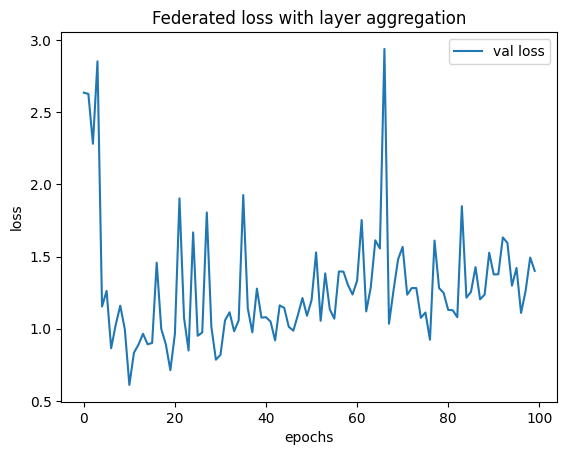

In [11]:
# ep = list(range(0, 100))

# # Plot the second list
# plt.plot(ep, val_loss, label='val loss')
# # Add labels and title
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.title('Federated loss with layer aggregation')
# # Add a legend
# plt.legend()
# # Show the plot
# plt.show()

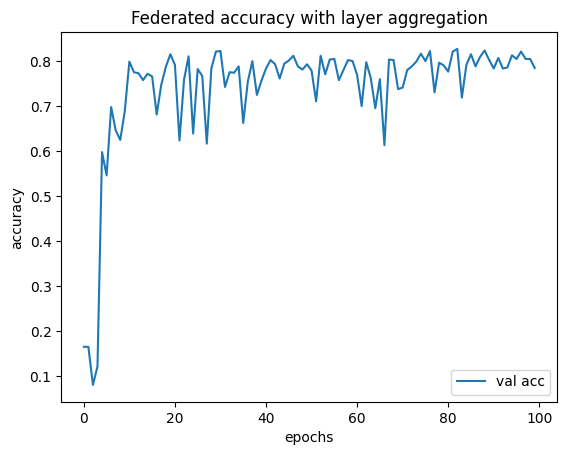

In [12]:
# ep = list(range(0, 100))
# # Plot the first list
# # Plot the second list
# plt.plot(ep, val_acc, label='val acc')
# # Add labels and title
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.title('Federated accuracy with layer aggregation')
# # Add a legend
# plt.legend()
# # Show the plot
# plt.show()

In [6]:
# Specify the folder containing the .keras files
file_path = "/mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.879-loss_0.661.keras"
y_test2 = np.argmax(y_test_encoded2, axis=1)

# # Use glob to find all .keras files in the folder
# keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
# for file_path in keras_files:
print(file_path)
best_model = load_model(file_path, compile = True)
    
y_pred = best_model.predict(x_test2, batch_size=40,  verbose=0)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(y_test2, sparse_pred)
print("Accuracy:", accuracy)

# Calculate macro-averaged AUC
macro_auc = roc_auc_score(y_test2, y_pred, multi_class="ovr", average="macro") 
print("macro_auc:", macro_auc)
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(y_test2, y_pred, multi_class="ovr", average="micro") 
print("micro_auc:", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd2_wght_dns.v_acc_0.879-loss_0.661.keras


2025-01-11 19:34:42.042992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:34:42.361393: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:34:42.422608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 236 bytes spill stores, 236 bytes spill loads

2025-01-11 19:34:53.302272: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:34:53.394910: I external/local_xla/xla/stream_exec

Accuracy: 0.8793744193248684
macro_auc: 0.987418204692786
micro_auc: 0.980834261902024


In [7]:
# Specify the folder containing the .keras files
folder_path = "/mnt/c/Users/Dhruba/Codes/saved models"
y_test3 = np.argmax(y_test_encoded3, axis=1)

# Use glob to find all .keras files in the folder
keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
for file_path in keras_files:
    print(file_path)
    best_model = load_model(file_path, compile = True)
        
    y_pred = best_model.predict(x_test3, batch_size=40,  verbose=0)
    sparse_pred = np.argmax(y_pred, axis=1)
    
    ### Calculate accuracy
    accuracy = accuracy_score(y_test3, sparse_pred)
    print("Accuracy:", accuracy)

    # Calculate macro-averaged AUC
    macro_auc = roc_auc_score(y_test3, y_pred, multi_class="ovr", average="macro") 
    print("macro_auc:", macro_auc)
    # Calculate micro-averaged AUC
    micro_auc = roc_auc_score(y_test3, y_pred, multi_class="ovr", average="micro") 
    print("micro_auc:", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/PBC_fd3_wght_dns.v_acc_0.988-loss_0.283.keras
Accuracy: 0.9879189399844115
macro_auc: 0.9993288674622456
micro_auc: 0.9993869776872852
/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.847-loss_1.790.keras


2025-01-11 19:37:08.888332: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:37:09.146891: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 172 bytes spill stores, 172 bytes spill loads



Accuracy: 0.0666406858924396


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [8]:
def split_dataset(x_test, y_test_encoded, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

# Split into 20 parts
splits = split_dataset(x_test, y_test_encoded, num_splits=20)

# Example: Check the size and classes in each split
for i, (x_split, y_split) in enumerate(splits):
    print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

20it [00:01, 11.76it/s]

Split 1: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 2: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 3: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 4: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 5: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 6: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 7: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 8: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 9: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 10: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 11: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 12: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 13: 127

In [14]:
x.shape

(1274, 128, 128, 3)

In [9]:
# Specify the folder containing the .keras files
folder_path = "/mnt/c/Users/Dhruba/Codes/saved models"
split_num = 20  #carefully check the total splits of test set

# Use glob to find all .keras files in the folder
keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
for file_path in keras_files:
    print(file_path)
    best_model = load_model(file_path, compile = True)
    accuracy_list = []
    mac_auc = []
    mic_auc = [] 
    for i in tqdm(range(split_num)):  
        x = splits[i][0]
        y = splits[i][1]
        
        y_pred = best_model.predict(x, batch_size=40,  verbose=0)
        sparse_pred = np.argmax(y_pred, axis=1)
        
        ### Calculate accuracy
        accuracy = accuracy_score(y, sparse_pred)
        #print("Accuracy:", accuracy)
        accuracy_list.append(accuracy)
    
        # Calculate macro-averaged AUC
        macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
        mac_auc.append(macro_auc)
        # Calculate micro-averaged AUC
        micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
        mic_auc.append(micro_auc)
       
    total_acc = sum(accuracy_list[:split_num])/split_num
    print("Accuracy of model on full test data: ", total_acc)
    
    macro_auc = sum(mac_auc[:split_num])/split_num
    print("Macro-averaged AUC on full test data: ", macro_auc)
    
    micro_auc = sum(mic_auc[:split_num])/split_num
    print("Micro-averaged AUC on full test data: ", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.847-loss_1.790.keras


  0%|                                                                                            | 0/20 [00:00<?, ?it/s]2025-01-11 19:39:11.279237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:39:11.559938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 172 bytes spill stores, 172 bytes spill loads

 50%|█████████████████████████████████████████▌                                         | 10/20 [00:27<00:12,  1.23s/it]2025-01-11 19:39:28.128748: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2025-01-11 19:39:28.497091: I external/local_xla/xla/stre

Accuracy of model on full test data:  0.8537080986240649
Macro-averaged AUC on full test data:  0.9863985092943308
Micro-averaged AUC on full test data:  0.9932038829570138


In [12]:
import lime
from lime import lime_image

In [13]:
explainer = lime_image.LimeImageExplainer()

In [24]:
image = x[0]
image = image.reshape(1, 128, 128, 3)
image.shape
#plt.imshow(image)

(1, 128, 128, 3)

In [25]:
prediction = best_model.predict(image)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[1.0000000e+00, 2.0519789e-35, 3.3012816e-27, 2.1093603e-28,
        2.1417733e-24, 3.7199522e-27, 1.5928573e-32, 1.7688522e-24,
        1.6956385e-18, 2.5068505e-34, 1.3045929e-32, 1.4001094e-25,
        1.1002549e-32, 4.7249318e-29, 2.6248807e-28, 3.7263479e-32]],
      dtype=float32)

In [44]:

# Explain the prediction using LIME
explanation = explainer.explain_instance(x[1000], best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

# Display the explanation
#explanation.segments

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

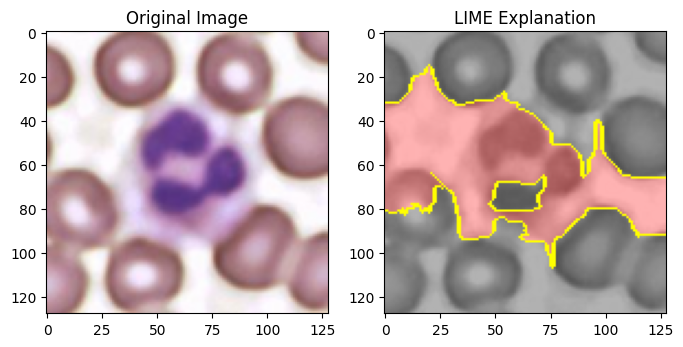

In [48]:
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Top predicted label
    positive_only=True,               # Show positive contributions only
    num_features=5,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)

# Overlay the mask on the original image
highlighted_image = label2rgb(mask, x[1000], bg_label=0)

# Plot the result
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(x[1000])

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(highlighted_image, mask))
plt.show()

In [15]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/WBCL_fd_dns.v_acc_0.822-loss_1.658.keras', compile = True)
#best_model.summary()

In [22]:
#y_pred = best_model.predict(x_test2, batch_size=40,  verbose=0)

sparse_gt = np.argmax(y_test_encoded2, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy: 0.03801807416640698


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [8]:
accuracy_list = []
CM = []
mac_auc = []
mic_auc = [] 
Y = []
Pred = []
for i in tqdm(range(20)):  
    x = splits[i][0]
    y = splits[i][1]
    
    # y_encoded = to_categorical(y)
    # best_model.evaluate(x, y_encoded, batch_size=40, verbose=1)
    
    y_pred = best_model.predict(x, batch_size=40,  verbose=0)
    
    ##sparse_gt = np.argmax(y, axis=0) ##y is already sparse here
    sparse_pred = np.argmax(y_pred, axis=1)
    
    ### Calculate accuracy
    accuracy = accuracy_score(y, sparse_pred)
    print("Accuracy:", accuracy)
    accuracy_list.append(accuracy)

    cm = confusion_matrix(y, sparse_pred)
    CM.append(cm)

    # Calculate macro-averaged AUC
    macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
    mac_auc.append(macro_auc)
    # Calculate micro-averaged AUC
    micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
    mic_auc.append(micro_auc)

    # # Calculate precision, recall, and F1-score for each class
    # precision = precision_score(y, sparse_pred, average=None)
    # recall = recall_score(y, sparse_pred, average=None)
    # f1 = f1_score(y, sparse_pred, average=None)
    
    # # Calculate macro, micro, and weighted scores
    # macro_f1 = f1_score(y, sparse_pred, average='macro')
    # micro_f1 = f1_score(y, sparse_pred, average='micro')
    # weighted_f1 = f1_score(y, sparse_pred, average='weighted')
    
    Y.append(y)
    Pred.append(sparse_pred)

  5%|████▏                                                                               | 1/20 [00:13<04:18, 13.58s/it]

Accuracy: 0.8549019607843137


 10%|████████▍                                                                           | 2/20 [00:14<01:54,  6.35s/it]

Accuracy: 0.8470588235294118


 15%|████████████▌                                                                       | 3/20 [00:16<01:07,  3.97s/it]

Accuracy: 0.8752941176470588


 20%|████████████████▊                                                                   | 4/20 [00:17<00:45,  2.85s/it]

Accuracy: 0.8737254901960785


 25%|█████████████████████                                                               | 5/20 [00:18<00:33,  2.23s/it]

Accuracy: 0.8392156862745098


 30%|█████████████████████████▏                                                          | 6/20 [00:19<00:26,  1.86s/it]

Accuracy: 0.8572549019607844


 35%|█████████████████████████████▍                                                      | 7/20 [00:20<00:21,  1.62s/it]

Accuracy: 0.8509803921568627


 40%|█████████████████████████████████▌                                                  | 8/20 [00:21<00:17,  1.47s/it]

Accuracy: 0.8447058823529412


 45%|█████████████████████████████████████▊                                              | 9/20 [00:22<00:15,  1.38s/it]

Accuracy: 0.8509803921568627


 50%|█████████████████████████████████████████▌                                         | 10/20 [00:24<00:13,  1.32s/it]

Accuracy: 0.8462745098039216


 55%|█████████████████████████████████████████████▋                                     | 11/20 [00:28<00:20,  2.26s/it]

Accuracy: 0.8485086342229199


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [00:29<00:15,  1.99s/it]

Accuracy: 0.8555729984301413


 65%|█████████████████████████████████████████████████████▉                             | 13/20 [00:30<00:12,  1.74s/it]

Accuracy: 0.8335949764521193


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:32<00:09,  1.58s/it]

Accuracy: 0.8540031397174255


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:33<00:07,  1.46s/it]

Accuracy: 0.8555729984301413


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [00:34<00:05,  1.38s/it]

Accuracy: 0.8469387755102041


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [00:35<00:03,  1.32s/it]

Accuracy: 0.8618524332810047


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [00:36<00:02,  1.26s/it]

Accuracy: 0.8610675039246468


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [00:38<00:01,  1.25s/it]

Accuracy: 0.8445839874411303


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.96s/it]

Accuracy: 0.8367346938775511


In [9]:
total_acc = sum(accuracy_list[:20])/20
print("Accuracy of model on full test data: ", total_acc)

macro_auc = sum(mac_auc[:20])/20
print("Macro-averaged AUC on full test data: ", macro_auc)

micro_auc = sum(mic_auc[:20])/20
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.8519411149075016
Macro-averaged AUC on full test data:  0.9851039109258766
Micro-averaged AUC on full test data:  0.9921935671442691


In [10]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv")
# Find unique values in the 'column_name' column
unique_values = df['label'].unique()
# Define the strings to remove
to_remove = ['artifact', 'unk_wbc']
# Find the indices of the strings to be removed
indices = [i for i, val in enumerate(unique_values) if val in to_remove]
# Delete the elements at the found indices
updated_class = np.delete(unique_values, indices)

print(len(updated_class))
sorted_class = np.sort(updated_class)
print(sorted_class)

16
['abnormal_lymphocyte' 'agg_plt' 'band_neutrophil' 'basophil' 'blast'
 'eosinophil' 'g_plt' 'immature_wbc' 'lymphocyte' 'metamyelocyte'
 'monocyte' 'myelocyte' 'n_rbc' 'promyelocyte' 'seg_neutrophil' 'smudge']


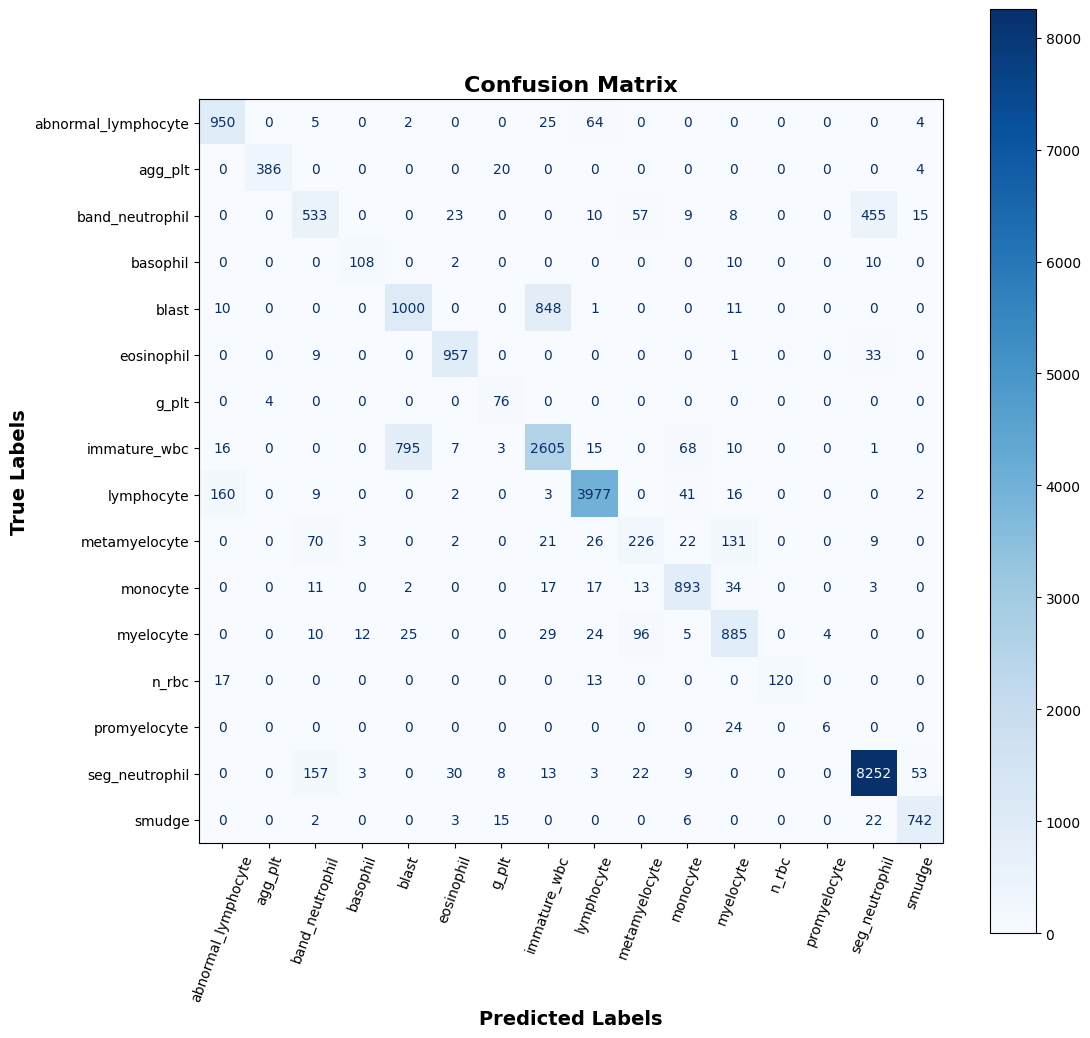

In [11]:
final_cm = sum(CM[:20])  # Sums up elements cm[0] to cm[19]

# Create display labels
class_names = sorted_class
plt.figure(figsize=(12, 12))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=70)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.ylabel("True Labels", fontsize=14, fontweight='bold')

#plt.tight_layout()
plt.show()

In [47]:
y_true = list(chain.from_iterable(Y))
y_gt = list(chain.from_iterable(Pred))

In [48]:
# Print classification report
report = classification_report(y_true, y_gt, target_names=[f"Class {i}" for i in range(16)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2090
     Class 1       1.00      1.00      1.00       808
     Class 2       1.00      1.00      1.00      2212
     Class 3       1.00      1.00      1.00       254
     Class 4       1.00      1.00      1.00      3724
     Class 5       1.00      1.00      1.00      1996
     Class 6       1.00      1.00      1.00       148
     Class 7       1.00      1.00      1.00      7038
     Class 8       1.00      1.00      1.00      8418
     Class 9       1.00      0.99      1.00      1012
    Class 10       1.00      1.00      1.00      1978
    Class 11       1.00      1.00      1.00      2174
    Class 12       1.00      1.00      1.00       286
    Class 13       1.00      1.00      1.00        48
    Class 14       1.00      1.00      1.00     17092
    Class 15       1.00      1.00      1.00      1564

    accuracy                           1.00     50842
  

In [63]:
chunk = 9
best_model.evaluate(x_test_chunk[chunk], y_test_encoded_chunk[chunk], batch_size=40, verbose=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9704 - loss: 0.1134


[0.20860594511032104, 0.9529227018356323]

In [62]:
y_pred = best_model.predict(x_test_chunk[9], batch_size=20,  verbose=1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [59]:
sparse_gt = np.argmax(y_test_encoded_chunk[chunk], axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

print(sparse_gt.shape)
print(sparse_pred.shape)

(2549,)
(2549,)


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

Accuracy: 0.5810121616320125
F1 Score (macro): 0.19237169640395446
F1 Score (micro): 0.5810121616320125
Recall (macro): 0.16690119834916214
Recall (micro): 0.5810121616320125
Precision (macro): 0.23675213675213677
Precision (micro): 0.5810121616320125


Confusion Matrix:


/root/miniconda3/envs/tff/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


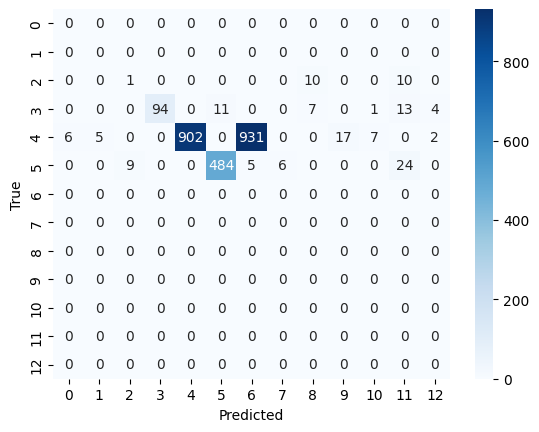

In [60]:
# Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
print("Accuracy:", accuracy)

# F1 Score (macro)
f1_macro = f1_score(sparse_gt, sparse_pred, average='macro')
print("F1 Score (macro):", f1_macro)

# F1 Score (micro)
f1_micro = f1_score(sparse_gt, sparse_pred, average='micro')
print("F1 Score (micro):", f1_micro)

# Recall (macro)
recall_macro = recall_score(sparse_gt, sparse_pred, average='macro')
print("Recall (macro):", recall_macro)

# Recall (micro)
recall_micro = recall_score(sparse_gt, sparse_pred, average='micro')
print("Recall (micro):", recall_micro)

# Precision (macro)
precision_macro = precision_score(sparse_gt, sparse_pred, average='macro')
print("Precision (macro):", precision_macro)

# Precision (micro)
precision_micro = precision_score(sparse_gt, sparse_pred, average='micro')
print("Precision (micro):", precision_micro)

# Confusion Matrix
cm = confusion_matrix(sparse_gt, sparse_pred)
print("\n\nConfusion Matrix:")
#print(cm)
# Visualize the confusion matrix using seaborn
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy is: 70.06669282071401
Sensitivity :  1.0
Specificity :  1.0
PPV :  1.0
NPV :  1.0


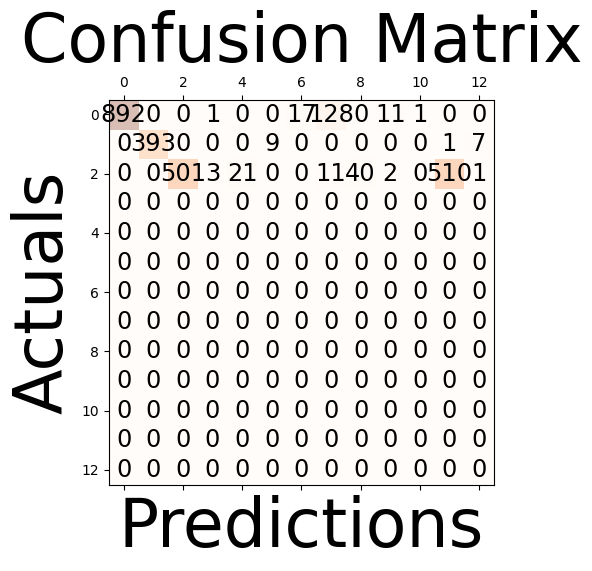

In [31]:
#y_pred = best_model.predict(x=X_test, batch_size = 300)    
a = accuracy_score(sparse_gt, sparse_pred.round())
print('Accuracy is:', a*100)

conf_matrix = confusion_matrix(y_true=sparse_gt, y_pred=sparse_pred.round())

sensitivity1 = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print('Specificity : ', specificity1)

PPV1 = conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1])
print('PPV : ', PPV1 )
NPV1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('NPV : ', NPV1)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=48)
plt.ylabel('Actuals', fontsize=48)
plt.title('Confusion Matrix', fontsize=48)
#plt.savefig('C:/Users/Dhruba/Codes/Slice_selection confusion_matrix.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [22]:
model.evaluate(x_test, y_test_encoded, batch_size=1, verbose=1)

25490/25490 ━━━━━━━━━━━━━━━━━━━━ 134s 5ms/step - accuracy: 0.7047 - loss: 0.7757


[0.49749448895454407, 0.8391526341438293]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)